<a href="https://colab.research.google.com/github/angelafrocha/ProjetoSoulcode/blob/main/An%C3%A1lise_venda_empresa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de vendas das empresas

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=630599a5cdefaf14a46e9470393eb749748a475d476c82be8caa6d1526779ad6
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 901.4 kB/s eta 0:00:00


In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, DateType
from pyspark.sql.functions import to_date, date_format
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.cloud import storage
import os
warnings.filterwarnings("ignore")
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, row_number

In [ ]:
# Congigurando chave GCP

#CONFIGURAR A CHAVE do google cloud
serviceAccount = '/content/spry-ether-382812-774986df1787.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
#Acessando a bucket criada
client = storage.Client()

bucket = client.get_bucket('projetofinal1')

bucket.blob('venda_empresa.csv')

path = 'gs://projetofinal1/tratados/venda_empresa.csv'


In [ ]:
#Criando uma sessão spark
spark = (SparkSession.builder
                     .master('local')
                     .appName('veiculos')
                     .config('spark.ui.port', '4050')
                     .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                     .getOrCreate())

In [ ]:
spark

In [ ]:
df = (
    spark.read
         .format('csv')
         .option('delimiter', ',')
         .option('header', 'true')
         .option('inferschema', 'true')
         .option('encoding','utf-8')
         .option('escape','"')
         .load('gs://projetofinal1/tratados/venda_empresa.csv')
)

In [ ]:
pd.set_option('display.max_columns',100)

Análise:

In [ ]:
df.show()

+----------------+------------+----------+----+
|      nome_marca|qtd_veiculos|   mes_ano| ano|
+----------------+------------+----------+----+
|            Audi|       677.0|2018-01-01|2018|
|             BMW|       757.0|2018-01-01|2018|
|            Mini|       143.0|2018-01-01|2018|
|      Caoa Chery|       397.0|2018-01-01|2018|
|         Hyundai|      1381.0|2018-01-01|2018|
|          Subaru|        63.0|2018-01-01|2018|
|        Chrysler|         0.0|2018-01-01|2018|
|           Dodge|        29.0|2018-01-01|2018|
|            Fiat|     13361.0|2018-01-01|2018|
|            Jeep|      7065.0|2018-01-01|2018|
|            Ford|     14972.0|2018-01-01|2018|
|  General Motors|     30246.0|2018-01-01|2018|
|Honda Automóveis|     10072.0|2018-01-01|2018|
|      Mitsubishi|       864.0|2018-01-01|2018|
|          Suzuki|       401.0|2018-01-01|2018|
|   Hyundai Motor|     12962.0|2018-01-01|2018|
|          Jaguar|       102.0|2018-01-01|2018|
|      Land Rover|       508.0|2018-01-0

In [ ]:
df.printSchema()

root
 |-- nome_marca: string (nullable = true)
 |-- qtd_veiculos: double (nullable = true)
 |-- mes_ano: date (nullable = true)
 |-- ano: integer (nullable = true)



In [ ]:
#SHAPE
print(f'({df.count()}, {len(df.columns)})')

(1749, 4)


In [ ]:
# Passando a coluna de quantidade de veículos para inteiro
df = df.withColumn("qtd_veiculos", F.col("qtd_veiculos").cast("integer"))

In [ ]:
df.printSchema()

root
 |-- nome_marca: string (nullable = true)
 |-- qtd_veiculos: integer (nullable = true)
 |-- mes_ano: date (nullable = true)
 |-- ano: integer (nullable = true)



In [ ]:
# VERIFICAÇÃO DAS VARIÁVEIS (média, mediana, valor mínimo, valor máximo)
lista_colunas = ['qtd_veiculos','ano']
df.select(lista_colunas).summary().show()

+-------+-----------------+------------------+
|summary|     qtd_veiculos|               ano|
+-------+-----------------+------------------+
|  count|             1749|              1749|
|   mean|5409.531732418525|2020.0977701543738|
| stddev|8067.503132056963|  1.52632905352494|
|    min|                0|              2018|
|    25%|              148|              2019|
|    50%|             1063|              2020|
|    75%|             9357|              2021|
|    max|            41349|              2023|
+-------+-----------------+------------------+



In [ ]:
# Quais as marcas mais vendidas?
df.groupBy('nome_marca').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).show()


+----------------+-------------+
|      nome_marca|total_vendido|
+----------------+-------------+
|  General Motors|      1655643|
|      Volkswagen|      1496127|
|            Fiat|      1076346|
|   Hyundai Motor|       936542|
|         Renault|       762535|
|          Toyota|       742748|
|            Jeep|       664564|
|            Ford|       542691|
|Honda Automóveis|       497199|
|          Nissan|       343544|
|      Caoa Chery|       128005|
|         Peugeot|       114822|
|         Citroën|       109329|
| Outras empresas|        98934|
|             BMW|        68188|
|      Mitsubishi|        46253|
|         Hyundai|        37478|
|            Audi|        37460|
|      Land Rover|        26995|
|   Mercedes-Benz|        22231|
+----------------+-------------+
only showing top 20 rows



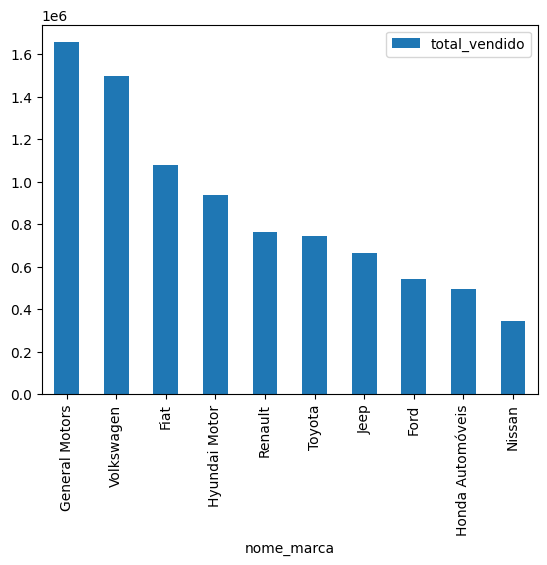

In [ ]:
# marcas mais vendidas
df_top_vendas = df.groupBy('nome_marca').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).limit(10)

df_plot = df_top_vendas.toPandas()

df_plot.plot(kind='bar', x='nome_marca', y='total_vendido')

plt.show()

In [ ]:
# Qual ano com mais vendas?
df.groupBy('ano').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).show()

+----+-------------+
| ano|total_vendido|
+----+-------------+
|2019|      2262073|
|2018|      2102114|
|2020|      1615942|
|2022|      1576666|
|2021|      1558467|
|2023|       346009|
+----+-------------+



In [ ]:
#Ordenado pelo ano
df.groupBy('ano').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('ano')).show()

+----+-------------+
| ano|total_vendido|
+----+-------------+
|2023|       346009|
|2022|      1576666|
|2021|      1558467|
|2020|      1615942|
|2019|      2262073|
|2018|      2102114|
+----+-------------+



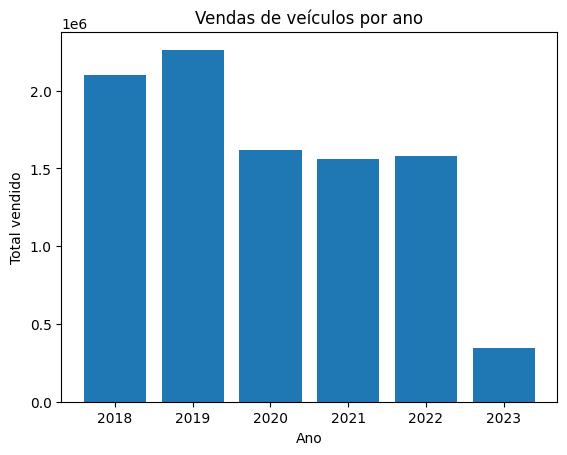

In [ ]:
# Vendas/ano
df_plot1 = df.groupBy('ano').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('ano')).toPandas()

# gerando o gráfico de barras
plt.bar(df_plot1['ano'], df_plot1['total_vendido'])
plt.xlabel('Ano')
plt.ylabel('Total vendido')
plt.title('Vendas de veículos por ano')
plt.show()

In [ ]:
# 10 marcas mais vendidas em 2020
df.filter(df.ano == 2020).groupBy('nome_marca').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).show(10)

+----------------+-------------+
|      nome_marca|total_vendido|
+----------------+-------------+
|  General Motors|       305285|
|      Volkswagen|       286114|
|            Fiat|       165873|
|   Hyundai Motor|       158294|
|         Renault|       120016|
|            Ford|       119454|
|            Jeep|       110163|
|          Toyota|       105485|
|Honda Automóveis|        84129|
|          Nissan|        52940|
+----------------+-------------+
only showing top 10 rows



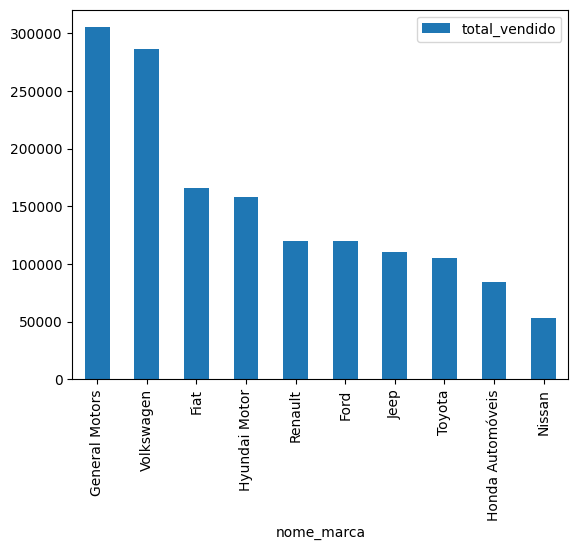

In [ ]:
# Gráfico 10 mais vendidos de 2020
df_vendas_2018 = df.filter(df.ano == 2020).groupBy('nome_marca').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).limit(10)

df_plot2 = df_vendas_2018.toPandas()

df_plot2.plot(kind='bar', x='nome_marca', y='total_vendido')

plt.show()

In [ ]:
# 10 marcas mais vendidas em 2021
df.filter(df.ano == 2021).groupBy('nome_marca').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).show(10)

+----------------+-------------+
|      nome_marca|total_vendido|
+----------------+-------------+
|      Volkswagen|       267647|
|            Fiat|       226567|
|  General Motors|       204919|
|   Hyundai Motor|       176793|
|            Jeep|       148786|
|          Toyota|       127059|
|         Renault|       105774|
|Honda Automóveis|        81454|
|          Nissan|        53120|
|      Caoa Chery|        39747|
+----------------+-------------+
only showing top 10 rows



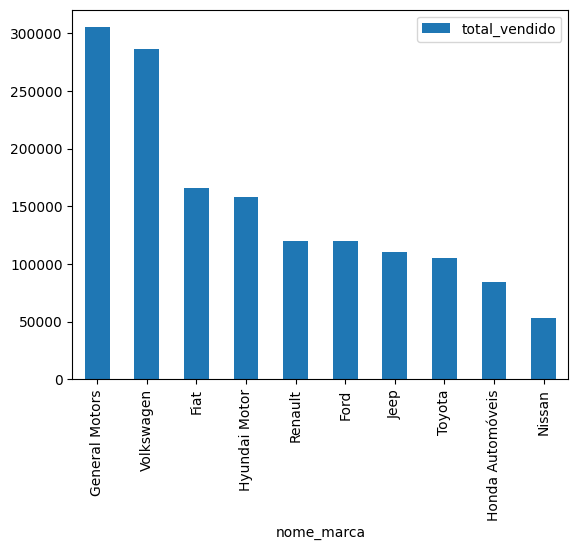

In [ ]:
# Gráfico 10 mais vendidos de 2021
df_vendas_2019 = df.filter(df.ano == 2021).groupBy('nome_marca').agg(F.sum('qtd_veiculos').alias('total_vendido')).orderBy(F.desc('total_vendido')).limit(10)

df_plot2 = df_vendas_2018.toPandas()

df_plot2.plot(kind='bar', x='nome_marca', y='total_vendido')

plt.show()